In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import xarray as xr
from jax import random
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
def generate_intermediate_counts(
    rng_key: UInt32[Array, "2"],
    n_series: int,
    t_max_train: int,
    t_max_test: int,
    a: float = 1.0,
    p: float = 0.5,
) -> tuple[
    Float32[Array, "t_max_train n_series"], Float32[Array, "t_max_test n_series"]
]:
    rng_key, rng_subkey = random.split(rng_key)
    lambdas = random.gamma(rng_subkey, a=a, shape=(1, n_series))

    t_max = t_max_train + t_max_test
    rng_key, rng_subkey = random.split(rng_key)
    counts = random.poisson(rng_subkey, lam=lambdas, shape=(t_max, n_series))
    counts = counts.astype(jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    counts = random.bernoulli(rng_subkey, p=p, shape=counts.shape) * counts

    return counts[:t_max_train, :], counts[t_max_train:, :]

In [3]:
counts_train, counts_test = generate_intermediate_counts(
    rng_key, n_series=500, t_max_train=50, t_max_test=10, a=10.0, p=0.3
)

series_ids = jnp.arange(counts_train.shape[1])

print(f"counts_train.shape: {counts_train.shape}")
print(f"counts_test.shape: {counts_test.shape}")

counts_train.shape: (50, 500)
counts_test.shape: (10, 500)


In [4]:
t_train: Float32[Array, " t_max_train"] = jnp.arange(counts_train.shape[0])
t_test: Float32[Array, " t_max_test"] = jnp.arange(
    counts_train.shape[0], counts_train.shape[0] + counts_test.shape[0]
)

In [5]:
t: Float32[Array, " t_max"] = jnp.concatenate([t_train, t_test])
counts: Float32[Array, "t_max n_series"] = jnp.concatenate([counts_train, counts_test])
counts_with_nans: Float32[Array, "t_max n_series"] = jnp.concatenate(
    [counts_train, jnp.full_like(counts_test, jnp.nan)]
)

assert counts.shape == (t.shape[0], series_ids.shape[0])
assert counts_with_nans.shape == (t.shape[0], series_ids.shape[0])

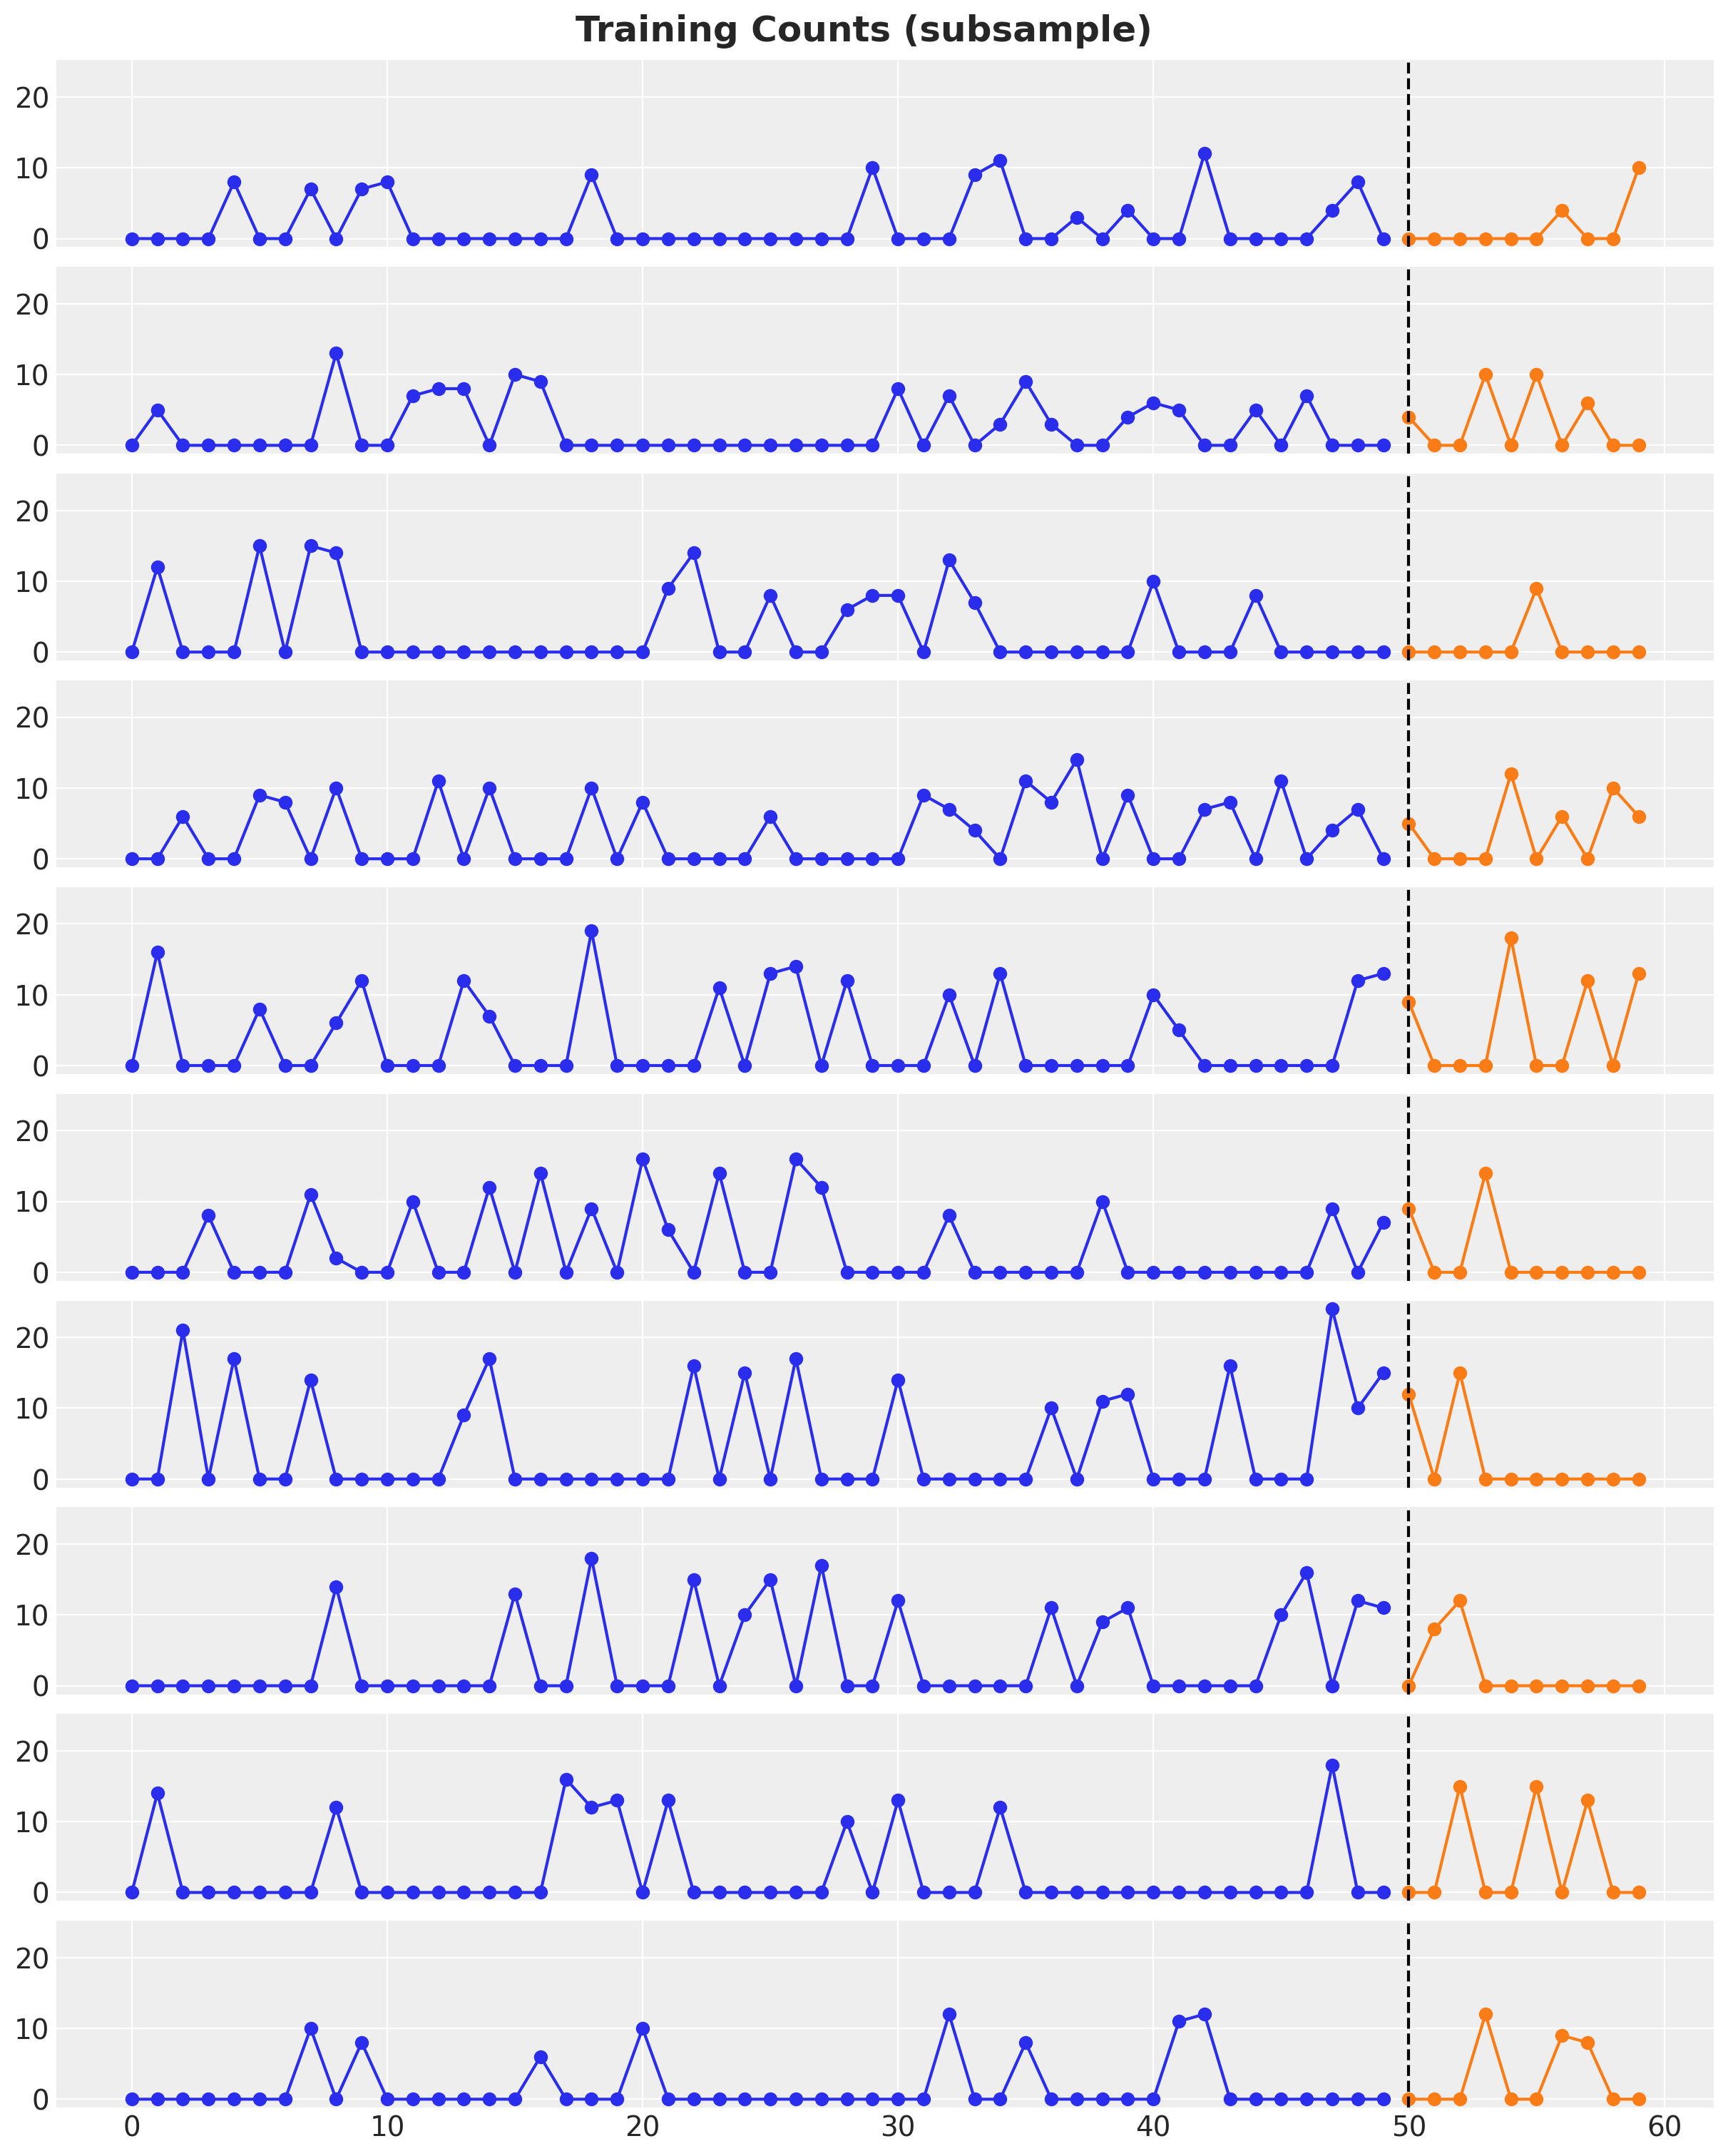

In [6]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(t_train, counts_train[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (subsample)", fontsize=18, fontweight="bold");

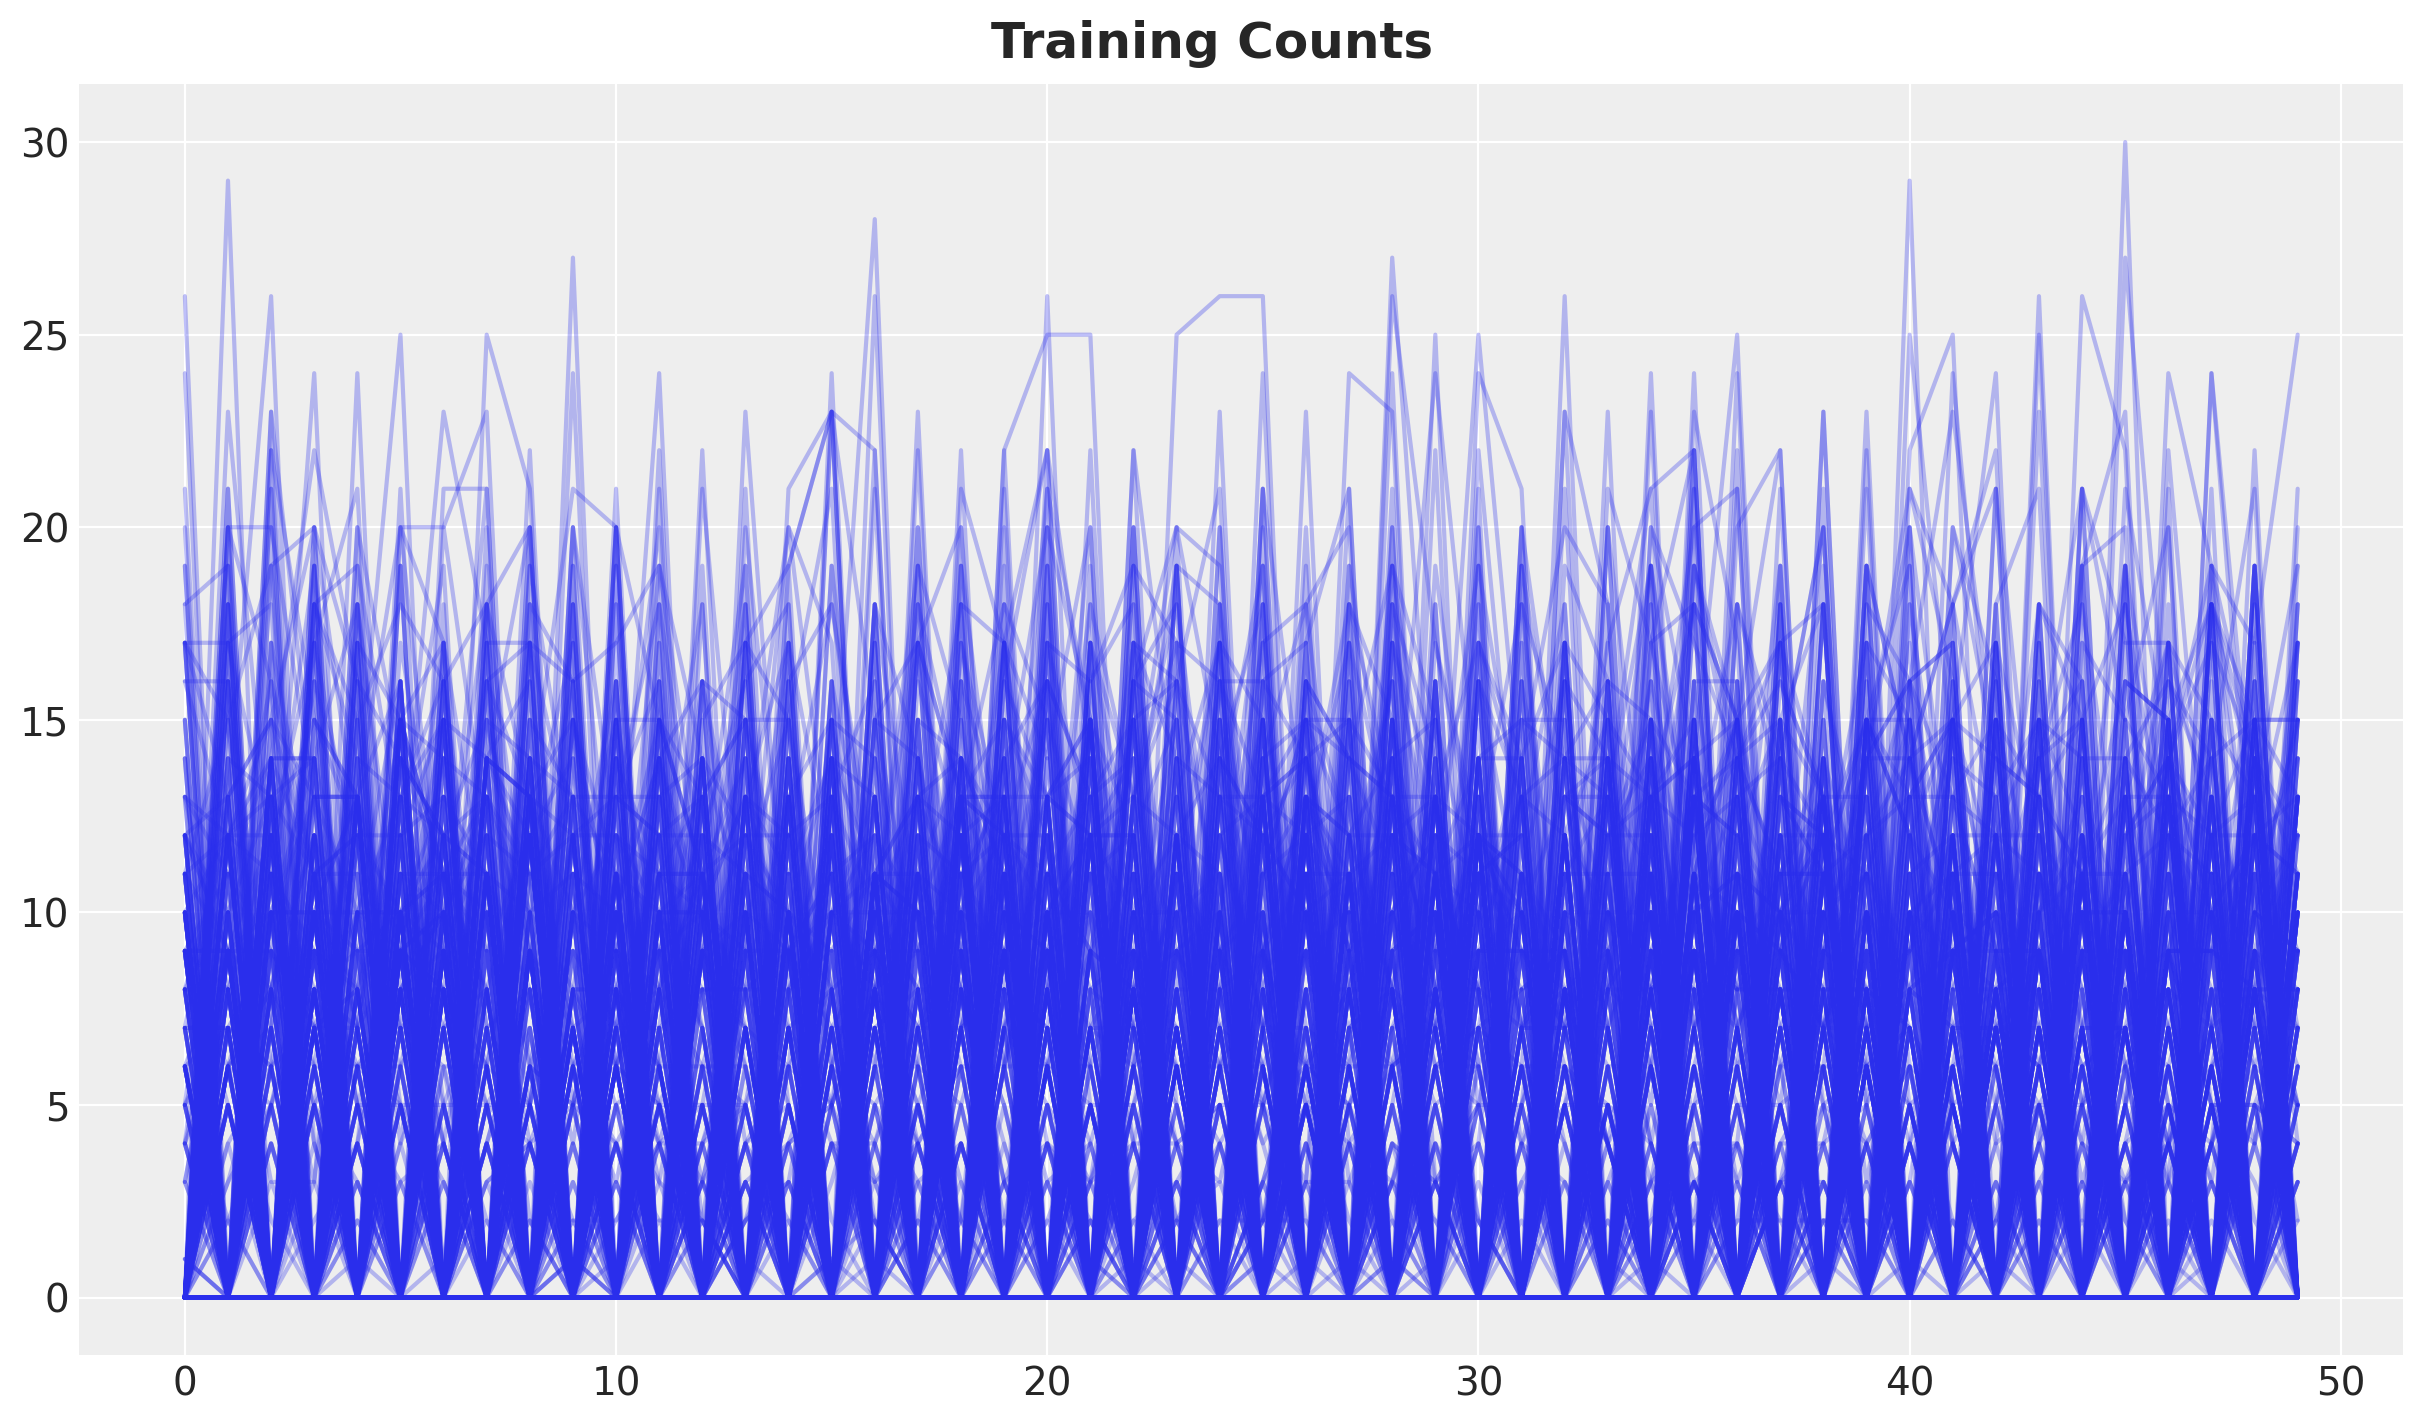

In [7]:
fig, ax = plt.subplots()
ax.plot(t_train, counts_train, c="C0", alpha=0.3)
fig.suptitle("Training Counts", fontsize=18, fontweight="bold");

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<Axes: >

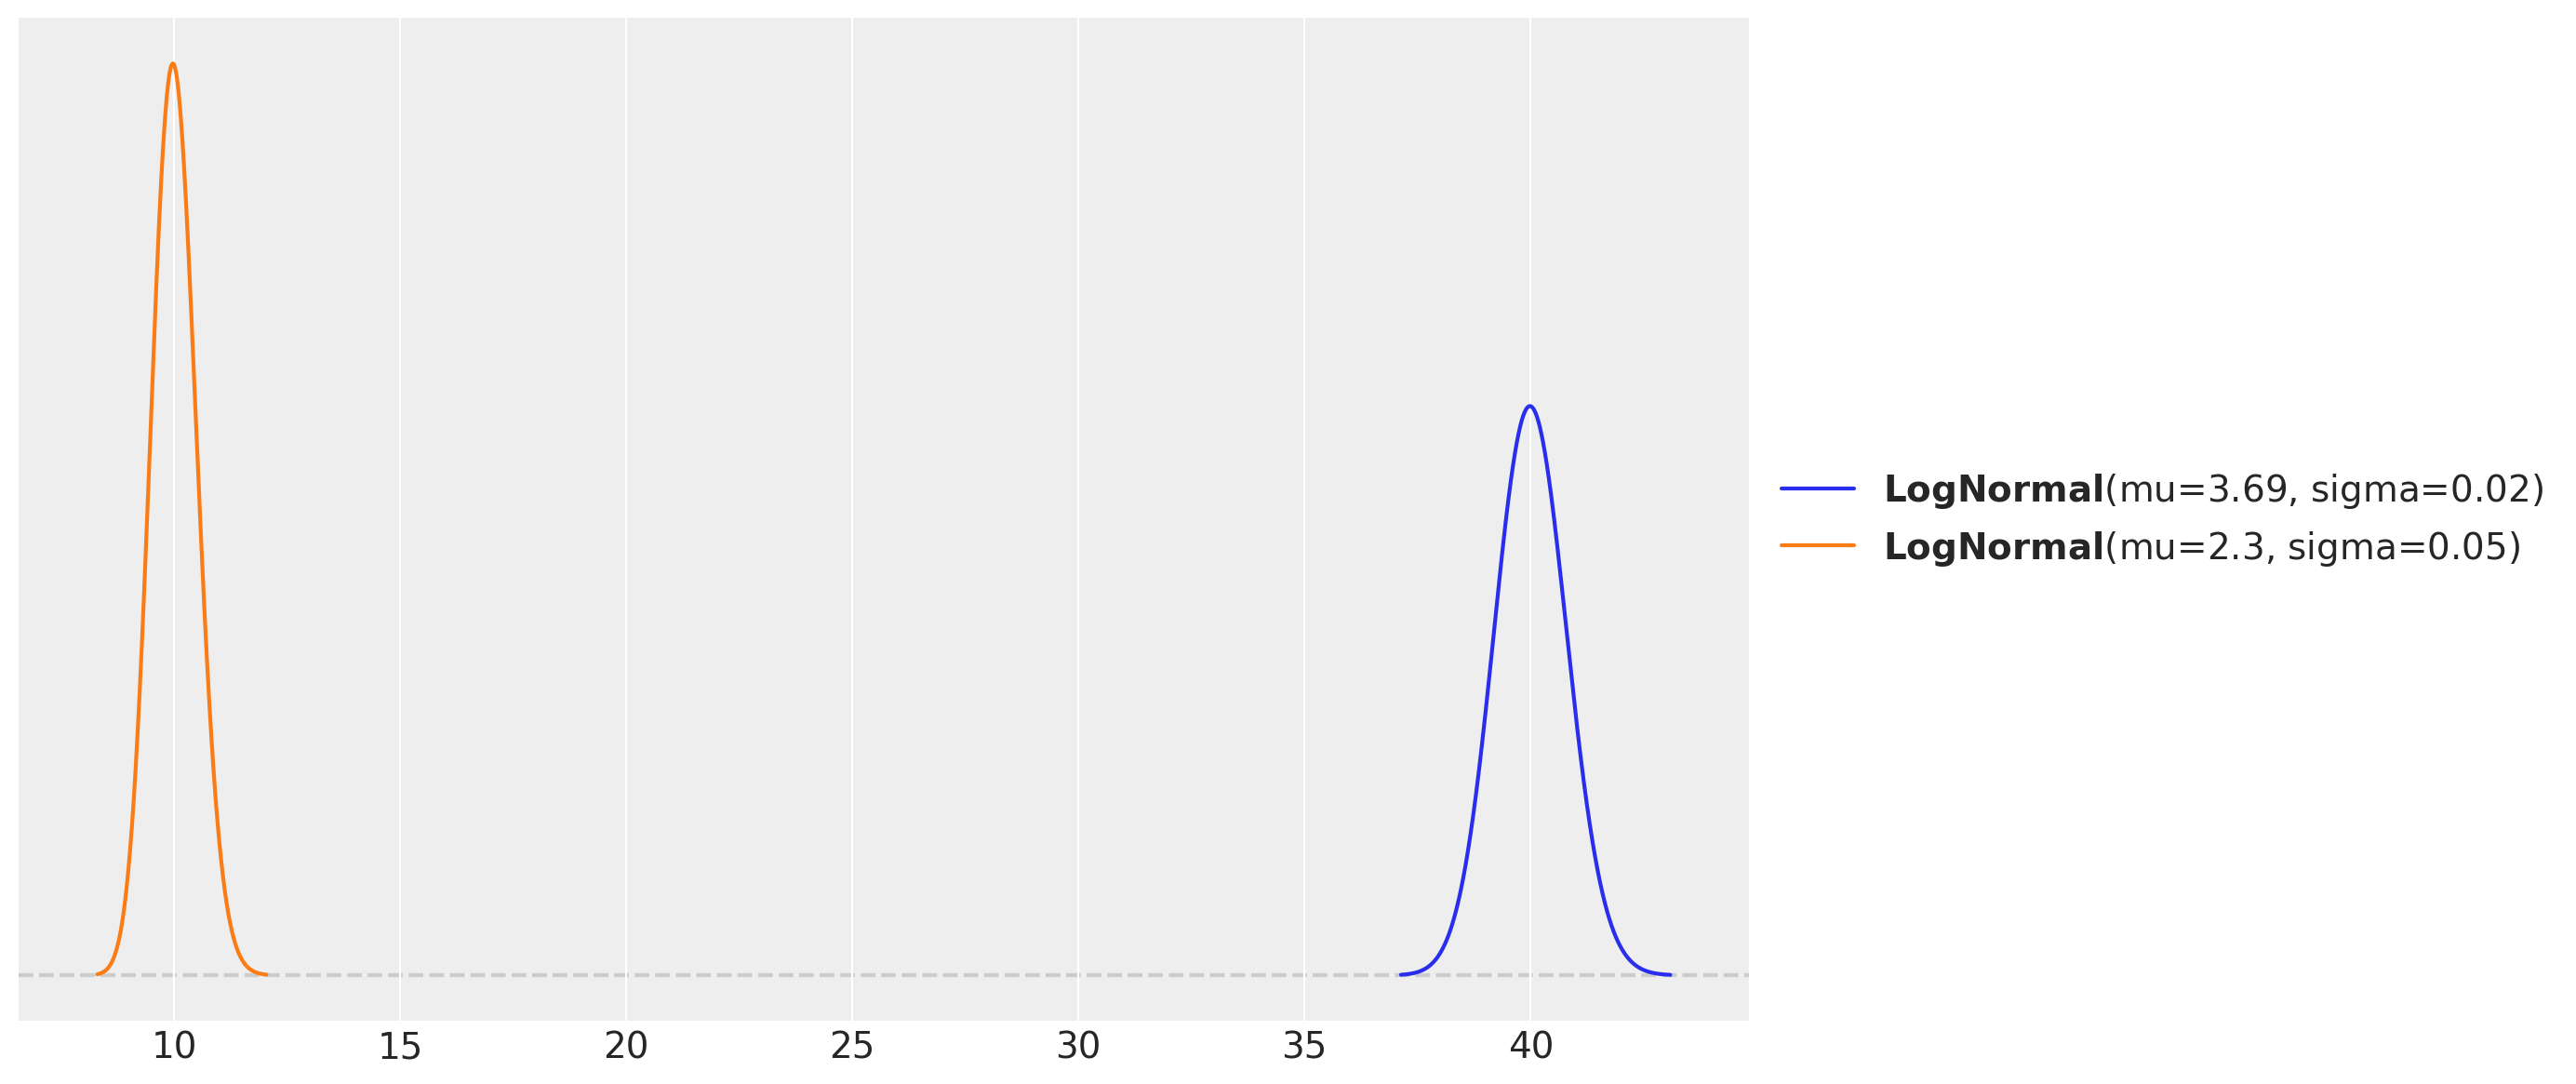

In [8]:
import preliz as pz

fig, ax = plt.subplots()
pz.LogNormal(mu=jnp.log(40), sigma=0.02).plot_pdf(ax=ax)
pz.LogNormal(mu=jnp.log(10), sigma=0.05).plot_pdf(ax=ax)

In [9]:
def model(
    counts: Float32[Array, "t_max n_series"], future: int = 0
) -> None | Float32[Array, "future n_series"]:
    t_max, n_series = counts.shape

    z_smoothing_concentration1 = numpyro.sample(
        "z_smoothing_concentration1", dist.LogNormal(loc=jnp.log(10), scale=0.05)
    )
    z_smoothing_concentration0 = numpyro.sample(
        "z_smoothing_concentration0", dist.LogNormal(loc=jnp.log(40), scale=0.02)
    )
    p_smoothing_concentration1 = numpyro.sample(
        "p_smoothing_concentration1", dist.LogNormal(loc=jnp.log(10), scale=0.05)
    )
    p_smoothing_concentration0 = numpyro.sample(
        "p_smoothing_concentration0", dist.LogNormal(loc=jnp.log(40), scale=0.02)
    )

    noise_scale = numpyro.sample(
        "noise_scale", dist.LogNormal(loc=jnp.log(10), scale=0.05)
    )

    with numpyro.plate("n_series", n_series):
        z_smoothing = numpyro.sample(
            "z_smoothing",
            dist.Beta(
                concentration1=z_smoothing_concentration1,
                concentration0=z_smoothing_concentration0,
            ),
        )

        p_smoothing = numpyro.sample(
            "p_smoothing",
            dist.Beta(
                concentration1=p_smoothing_concentration1,
                concentration0=p_smoothing_concentration0,
            ),
        )

        noise = numpyro.sample("noise", dist.HalfNormal(scale=noise_scale))

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                z_smoothing * counts[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max,
            jnp.where(
                counts[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next * p_next

        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": counts}):
        _, preds = scan(
            transition_fn,
            (counts[0], 0.5 * jnp.ones_like(counts[0])),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("forecast", preds[-future:])
    return None

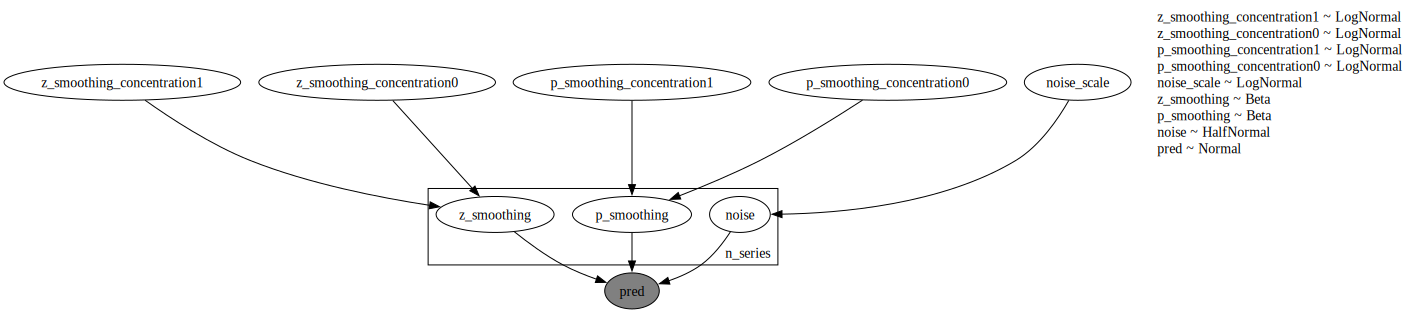

In [10]:
numpyro.render_model(
    model=model,
    model_kwargs={"counts": counts_train},
    render_distributions=True,
    render_params=True,
)

100%|██████████| 80000/80000 [00:29<00:00, 2706.55it/s, init loss: 1033270.5625, avg. loss [76001-80000]: -258100.3299]


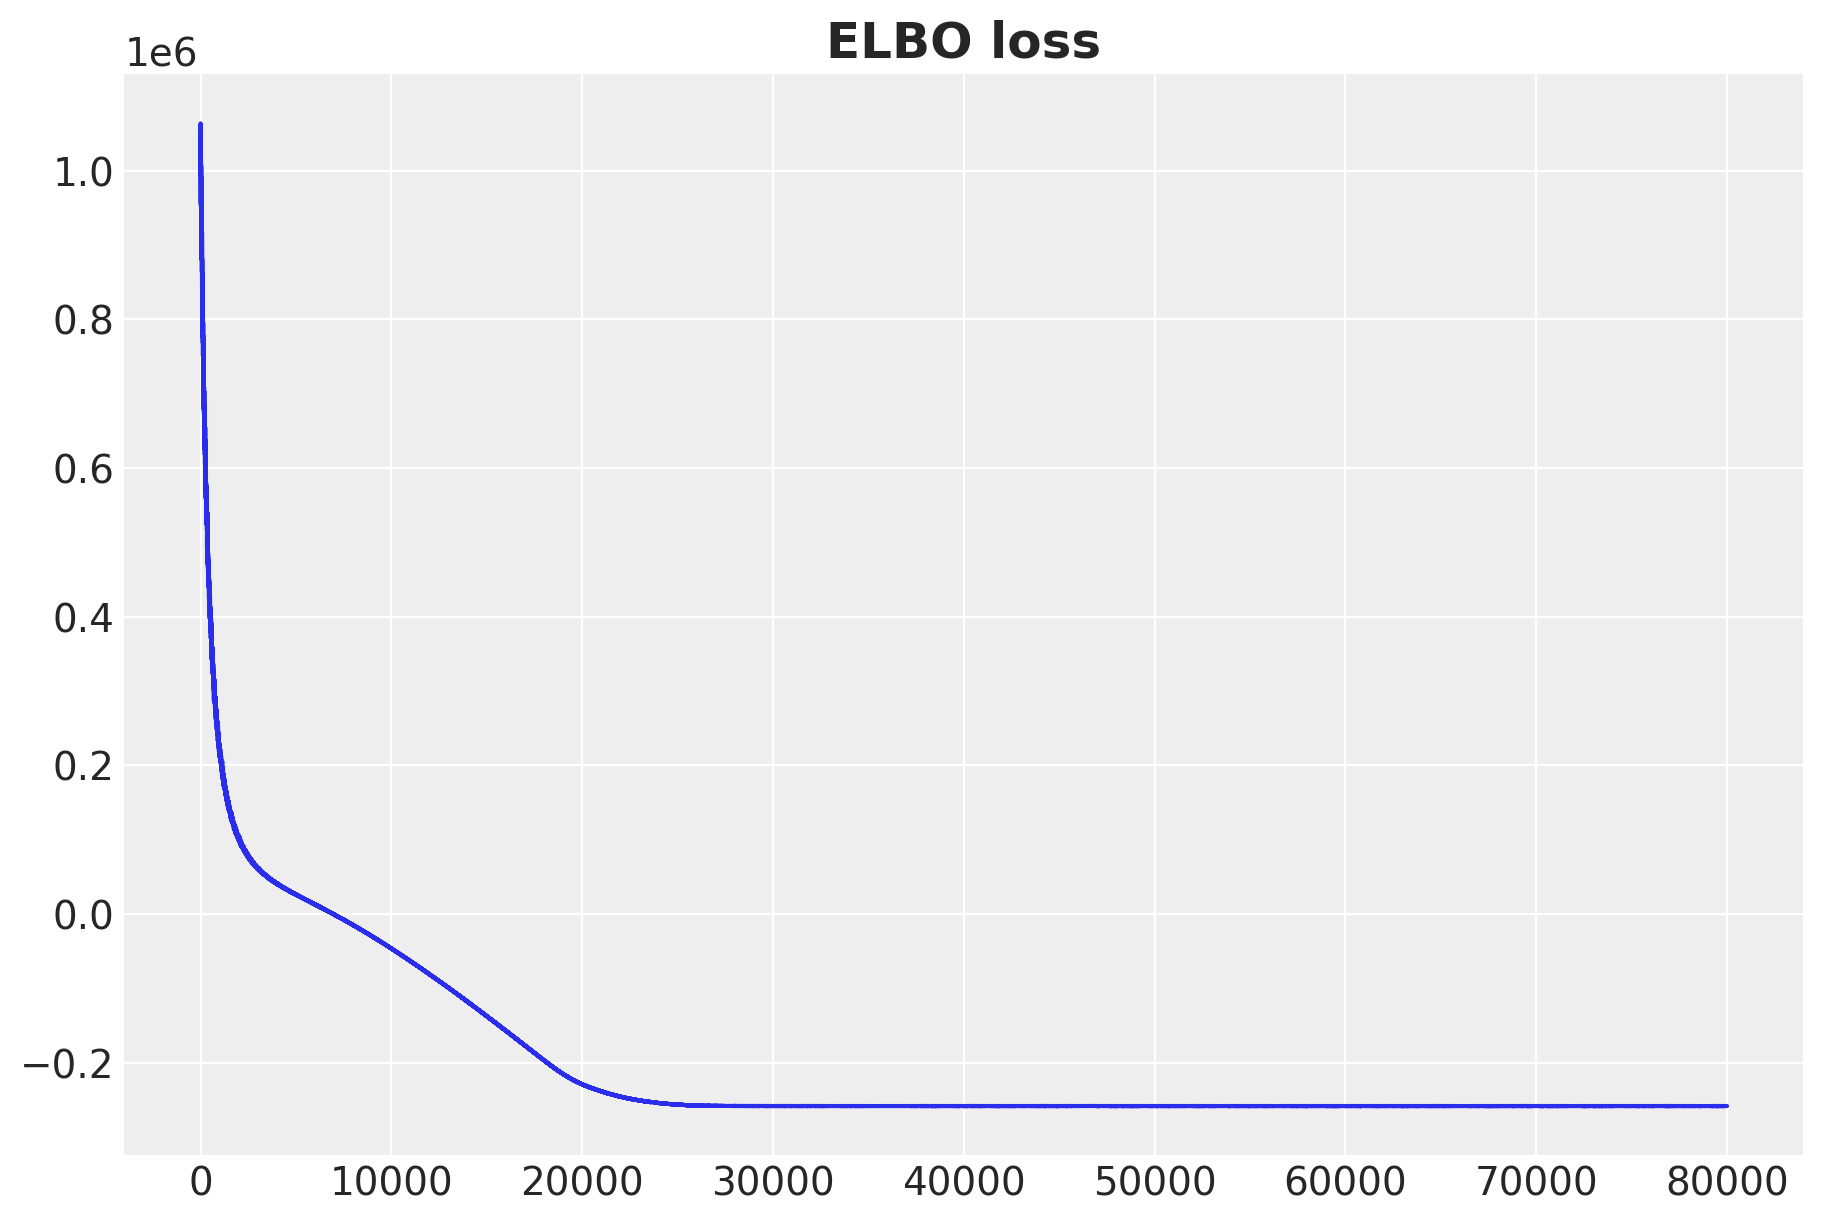

In [11]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 80_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    counts_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
# ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [12]:
posterior_predictive = Predictive(
    model=model,
    params=svi_result.params,
    num_samples=1_000,
    return_sites=["forecast"],
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, counts_train, future=t_test.shape[0]
)

posterior_predictive_idata = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior_predictive_samples.items()
    },
    coords={"t_max": t_test, "n_series": series_ids},
    dims={"forecast": ["t_max", "n_series"]},
)

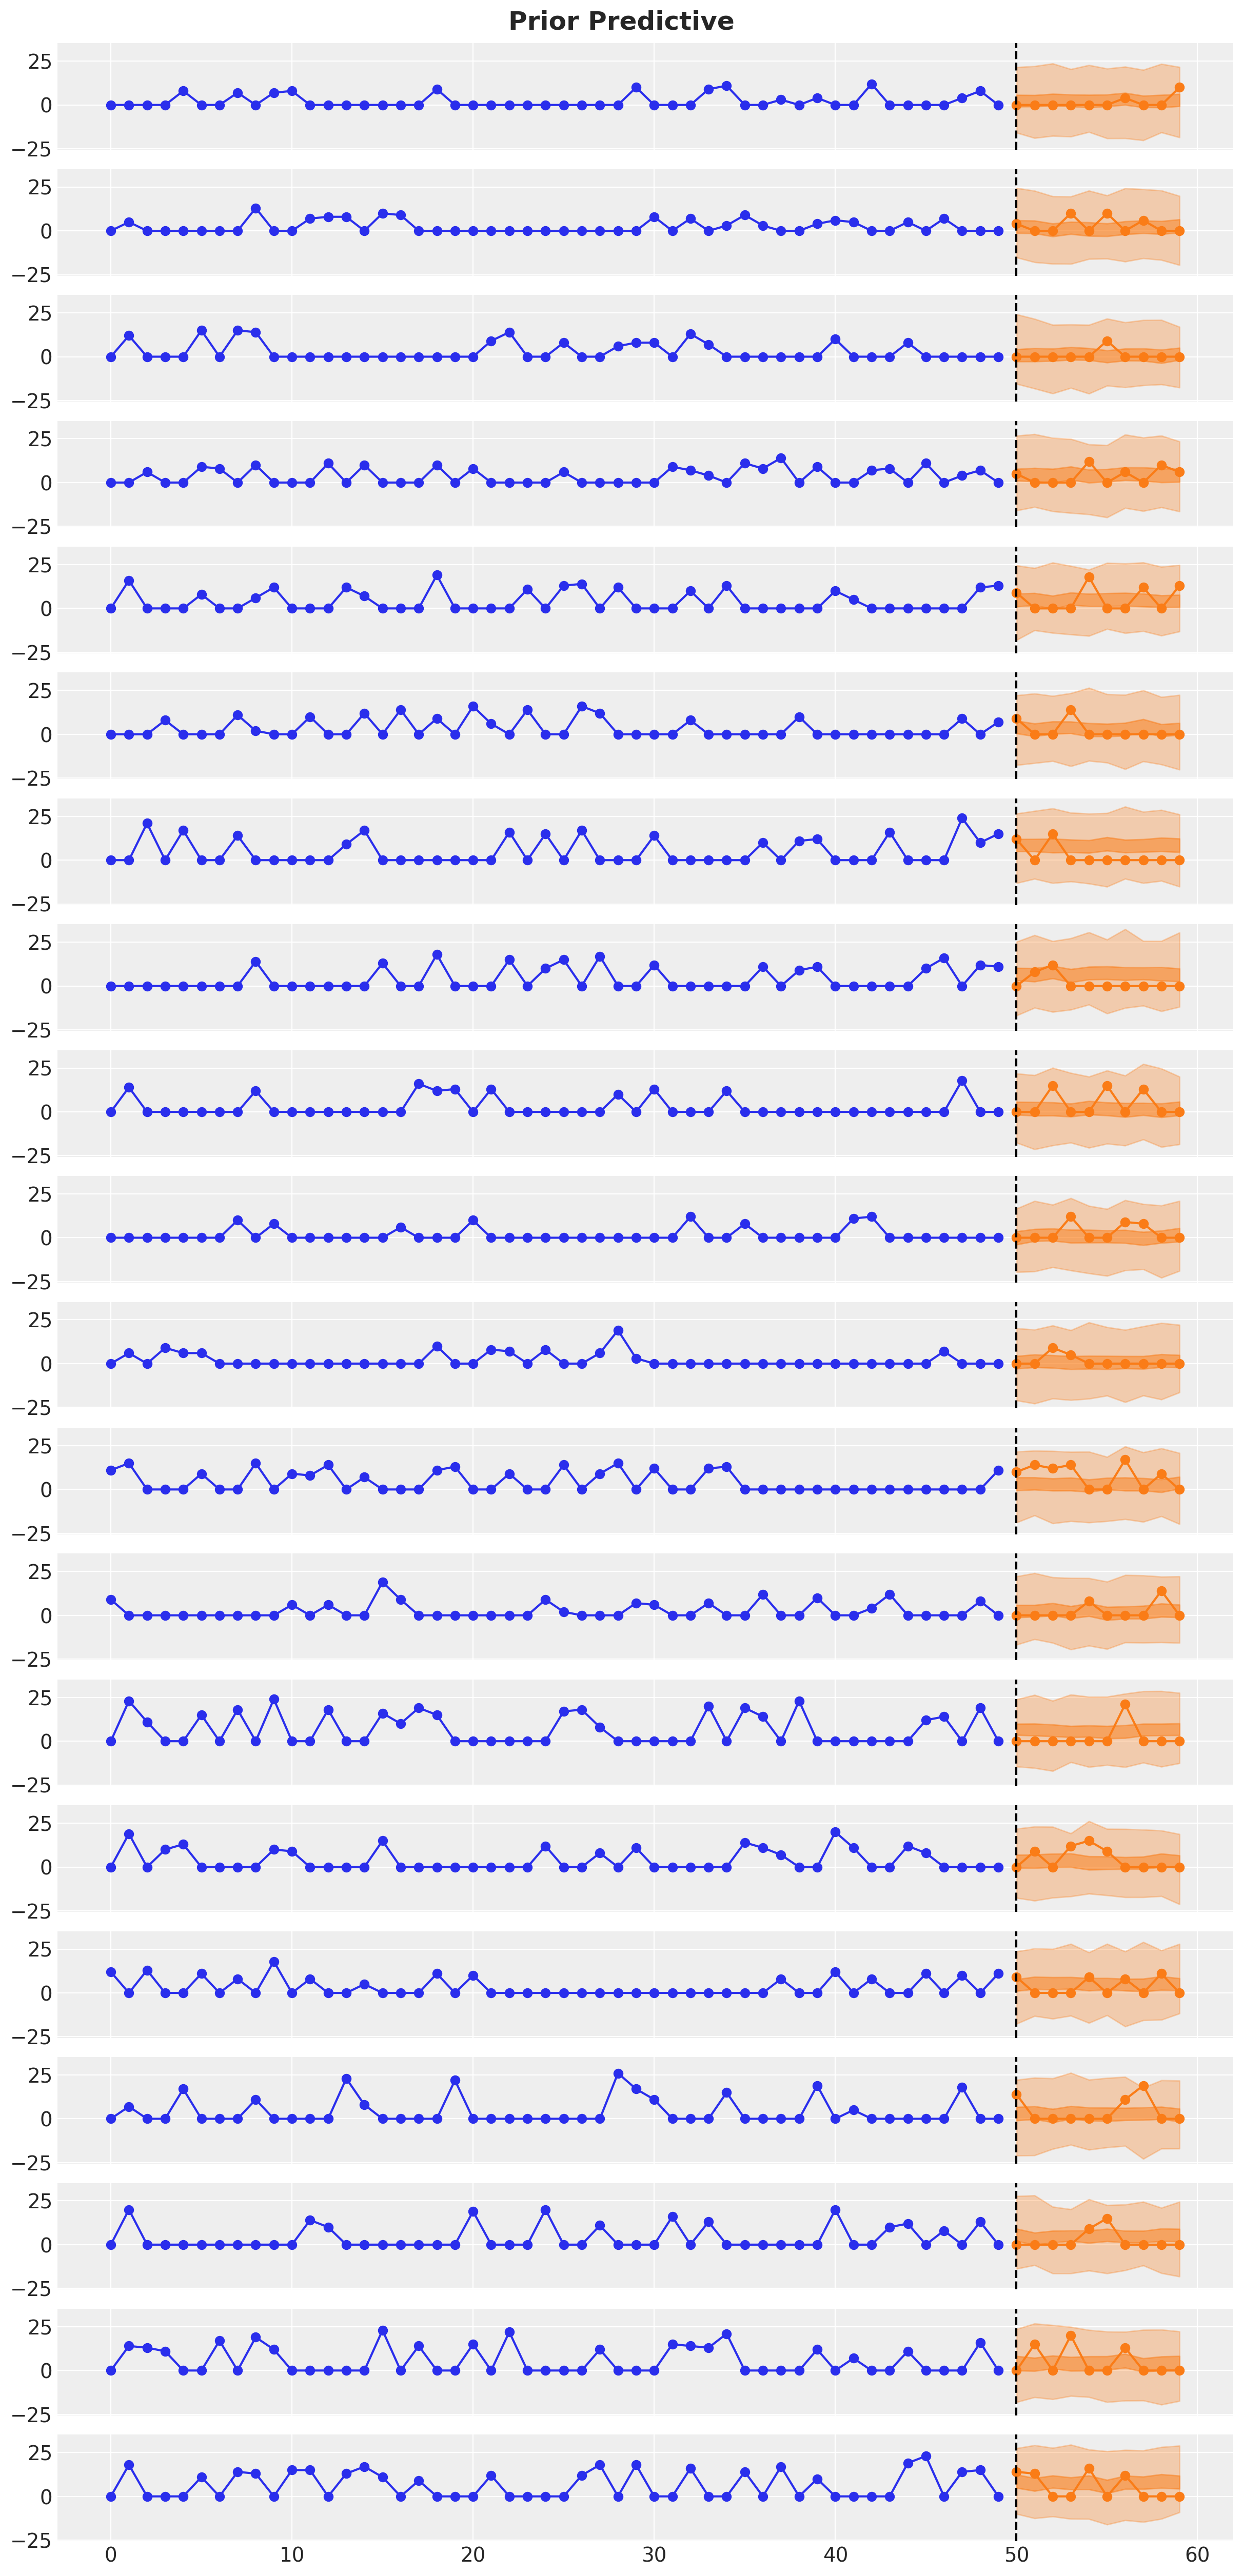

In [13]:
n_series_to_plot = 20

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in series_ids[:n_series_to_plot]:
    az.plot_hdi(
        t_test,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3},
        smooth=False,
        ax=ax[i],
    )
    az.plot_hdi(
        t_test,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax[i],
    )

    ax[i].plot(t_train, counts_train[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Prior Predictive", fontsize=18, fontweight="bold");

In [50]:
def time_slice_cross_validation(
    rng_key: UInt32[Array, "2"],
    y: Float32[Array, "t_max n_series"],
    n_splits: int = 5,
) -> xr.Dataset:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        y_train = y[: -(n_splits - i), :]

        # Inference
        guide = AutoNormal(model)
        optimizer = numpyro.optim.Adam(step_size=0.001)
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
        num_steps = 1_000

        rng_key, rng_subkey = random.split(key=rng_key)
        svi_result = svi.run(
            rng_subkey,
            num_steps,
            y_train,
        )

        # Forecast
        posterior_predictive = Predictive(
            model=model, guide=guide, num_samples=1_000, return_sites=["forecast"]
        )

        rng_key, rng_subkey = random.split(rng_key)
        posterior_predictive = Predictive(
            model=model,
            params=svi_result.params,
            num_samples=1_000,
            return_sites=["forecast"],
        )

        rng_key, rng_subkey = random.split(rng_key)
        posterior_predictive_samples = posterior_predictive(
            rng_subkey, counts_train, future=1
        )

        posterior_predictive_idata = az.from_dict(
            posterior_predictive={
                k: v[None, ...] for k, v in posterior_predictive_samples.items()
            },
            coords={"t_max": [y_train.shape[0]], "n_series": series_ids},
            dims={"forecast": ["t_max", "n_series"]},
        )

        forecast_list.append(posterior_predictive_idata)

    # Concatenate forecasts
    return xr.concat(
        [x["posterior_predictive"] for x in forecast_list],
        dim=("t_max"),
    )

In [51]:
r = time_slice_cross_validation(rng_key, counts, n_splits=t_test.shape[0])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 597.93it/s, init loss: 1317082.0000, avg. loss [951-1000]: 296209.5975]


TypeCheckError: Type-check error whilst checking the return value of __main__.time_slice_cross_validation.
Actual value: <xarray.Dataset> Size: 20MB
Dimensions:   (chain: 1, draw: 1000, t_max: 10, n_series: 500)
Coordinates:
  * chain     (chain) int64 8B 0
  * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * t_max     (t_max) int64 80B 50 51 52 53 54 55 56 57 58 59
  * n_series  (n_series) int32 2kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    forecast  (chain, draw, t_max, n_series) float32 20MB 19.61 5.167 ... 16.28
Attributes:
    created_at:     2024-11-24T09:54:30.365675+00:00
    arviz_version:  0.20.0
Expected type: xarray.core.dataset.Dataset.
----------------------
Called with parameters: {'rng_key': u32[2], 'y': f32[60,500], 'n_splits': 10}
Parameter annotations: (rng_key: UInt32[Array, '2'], y: Float32[Array, 't_max n_series'], n_splits: int = 5) -> Any.
The current values for each jaxtyping axis annotation are as follows.
t_max=60
n_series=500

In [45]:
r[2]["posterior_predictive"]["forecast"]

<xarray.DataArray 'forecast' (chain: 1, draw: 1000, t_max: 1, n_series: 500)> Size: 2MB
array([[[[  6.608651  ,   0.6965975 ,  11.317691  , ...,  -9.382155  ,
            3.8610935 ,  13.5725355 ]],

        [[  6.229943  ,  -9.441804  ,  -1.5276634 , ...,  19.998547  ,
            3.2040355 ,  -0.20518485]],

        [[  6.655998  ,  -0.39823774,   2.874407  , ...,  -5.793162  ,
           27.366234  ,  19.813568  ]],

        ...,

        [[  3.1955433 ,   2.2685883 ,  -5.989257  , ..., -39.58633   ,
            4.2436757 ,  -3.6915743 ]],

        [[ -9.531113  ,   1.9125046 ,   5.2582445 , ...,   1.1673933 ,
            2.0351162 ,  31.104006  ]],

        [[  9.194915  ,   1.5304165 , -10.377422  , ...,  15.873656  ,
          -17.40071   ,   4.2447124 ]]]], dtype=float32)
Coordinates:
  * chain     (chain) int64 8B 0
  * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * t_max     (t_max) int64 8B 59
  * n_series  (n_series) int32 2kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499

In [46]:
t_test

Array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int32)